In [5]:
import sys
import os
import pandas as pd

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, ".."))

run_results = pd.read_parquet(
    os.path.abspath(
        os.path.join(notebook_dir, "../../cache/parquet/analysis.parquet")
    )
)

print(run_results)

      season  week     gameId gameDisplay           gameDate homeTeamId  \
0       2024     9  401671493  MIA vs BUF  2024-11-03T18:00Z          2   
1       2024     9  401671623  DEN vs BAL  2024-11-03T18:00Z         33   
2       2024     9  401671629  LAC vs CLE  2024-11-03T18:00Z          5   
3       2024     9  401671647  IND vs MIN  2024-11-04T01:20Z         16   
4       2024     9  401671650   NO vs CAR  2024-11-03T18:00Z         29   
...      ...   ...        ...         ...                ...        ...   
1830    2015     3  400791597   SF vs ARI  2015-09-27T20:05Z         22   
1831    2015     3  400791623  BUF vs MIA  2015-09-27T20:25Z         15   
1832    2015     3  400791626  CHI vs SEA  2015-09-27T20:25Z         26   
1833    2015     3  400791631  DEN vs DET  2015-09-28T00:30Z          8   
1834    2015     3  400791635    KC vs GB  2015-09-29T00:30Z          9   

     homeTeamDisplay  homeScore awayTeamId awayTeamDisplay  ...  neutralField  \
0                B

In [27]:
total = len(run_results.index)

def process_totals():
    print("total", len(run_results.index))
    print("home selected", len(run_results[run_results["grade"] >= 2].index) / total)
    print("away selected", len(run_results[run_results["grade"] <= -2].index) / total)
    print("unknown", len(run_results[run_results["grade"].abs() == 1].index) / total)

def analyze_boundries(label, boundry):
    print(f"---{label}---")
    chosen = run_results[run_results[label].abs() >= boundry]

    correct = chosen[
        ((chosen[label] >= boundry) & (chosen["expected"] == True))
        | ((chosen[label] <= -boundry) & (chosen["expected"] == False))
    ]

    home_selected = chosen[(chosen[label] >= boundry)]
    home_correct = correct[(correct[label] >= boundry)]

    print("accuracy", len(correct.index) / len(chosen.index))
    print("chosen", len(chosen.index), len(chosen.index) / total)
    print("correct", len(correct.index))
    print("home_selected", len(home_selected.index))
    print("home_correct", len(home_correct.index))


process_totals()
analyze_boundries('grade', 2)
analyze_boundries('playerRating', 200)
analyze_boundries('teamRating', 200)
analyze_boundries('statsRating', 200)


total 1835
home selected 0.39400544959128064
away selected 0.4316076294277929
unknown 0.17438692098092642
---grade---
accuracy 0.5907590759075908
chosen 1515 0.8256130790190735
correct 895
home 462
---playerRating---
accuracy 0.6561679790026247
chosen 381 0.20762942779291554
correct 250
home 133
---teamRating---
accuracy 0.6518375241779497
chosen 517 0.28174386920980926
correct 337
home 174
---statsRating---
accuracy 0.6096096096096096
chosen 999 0.5444141689373297
correct 609
home 313


/var/folders/sx/xmtc134d0w520kgzwx2q0zsh0000gn/T/ipykernel_86819/3372073095.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  home = correct[(chosen[label] >= boundry) & (chosen["expected"] == True)]


In [7]:
import numpy as np
import seaborn as sbn

from scipy import stats

reduced = run_results[(np.abs(stats.zscore(run_results[
    ['statsRating', 'playerRating', 'teamRating']
])) < 3).all(axis=1)].copy()

reduced['merge'] = reduced['playerRating'] + reduced['teamRating'] + reduced['statsRating']
reduced['diff'] = reduced['homeScore'] - reduced['awayScore']
reduced['gameRating'] = reduced['homeRating'] - reduced['awayRating']


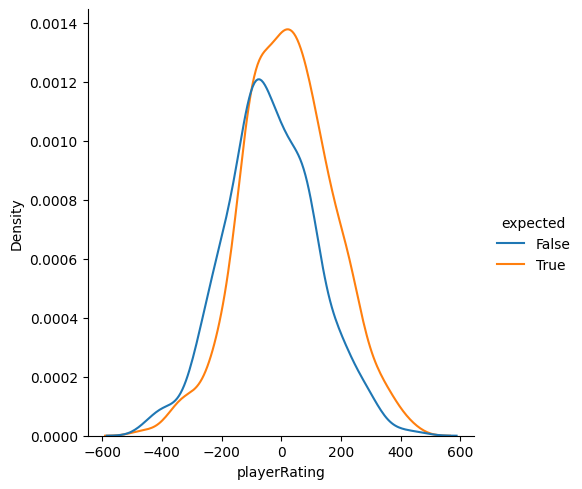

In [8]:
sbn.displot(data=reduced, x="playerRating", hue='expected', kind="kde")

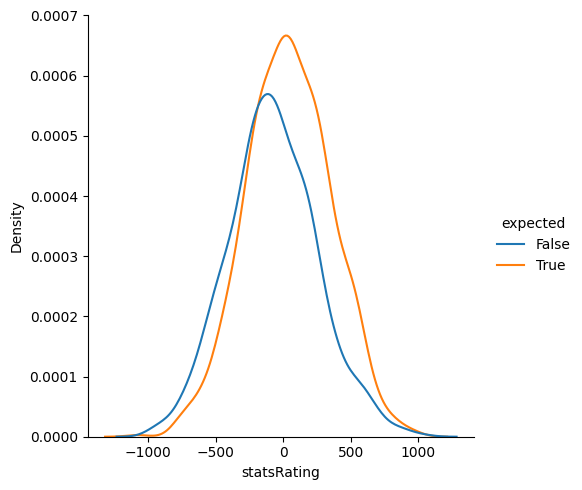

In [9]:
sbn.displot(data=reduced, x="statsRating", hue='expected', kind="kde")

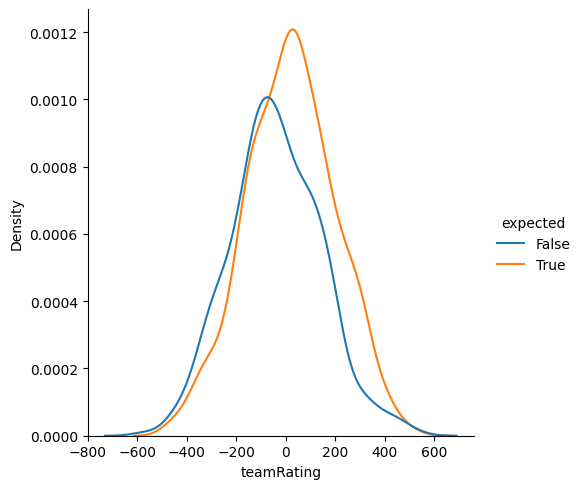

In [10]:
sbn.displot(data=reduced, x="teamRating", hue='expected', kind="kde")

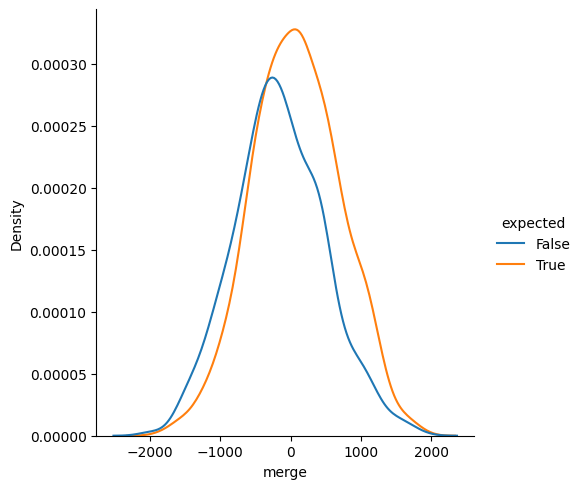

In [12]:
sbn.displot(data=reduced, x="merge", hue='expected', kind="kde")

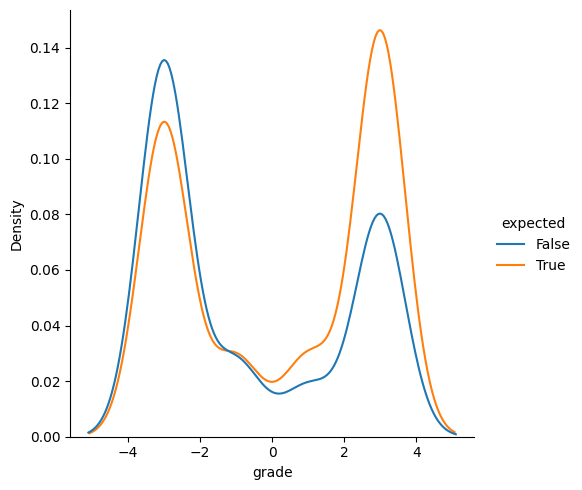

In [11]:
sbn.displot(data=reduced, x="grade", hue='expected', kind="kde")

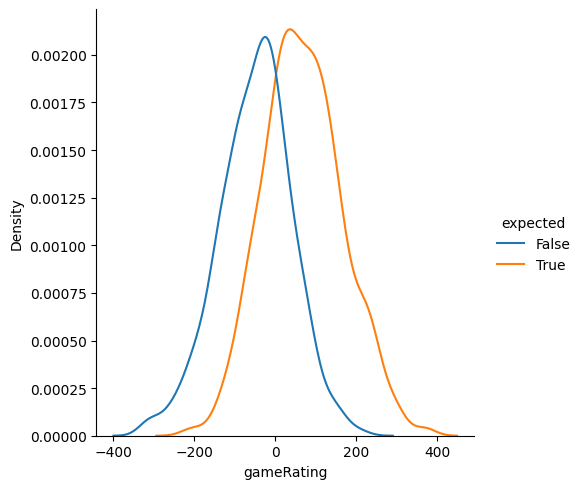

In [13]:
sbn.displot(data=reduced, x="gameRating", hue='expected', kind="kde")

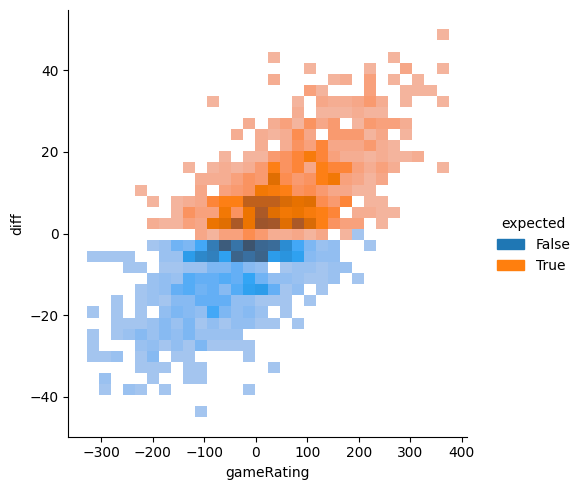

In [14]:
sbn.displot(data=reduced, x="gameRating", y="diff", hue='expected')

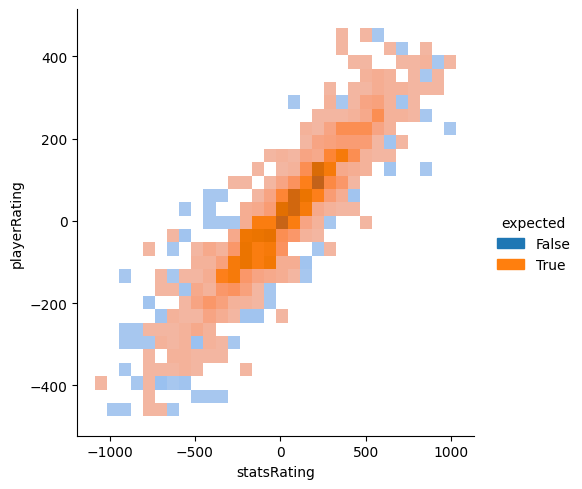

In [16]:
sbn.displot(data=reduced, x="statsRating", y="playerRating", hue='expected')

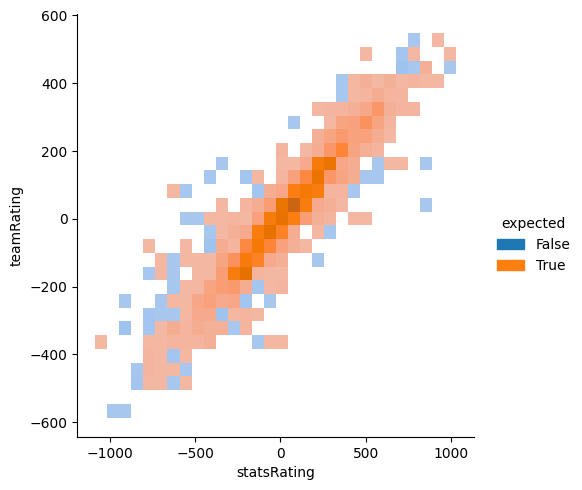

In [17]:
sbn.displot(data=reduced, x="statsRating", y="teamRating", hue='expected')

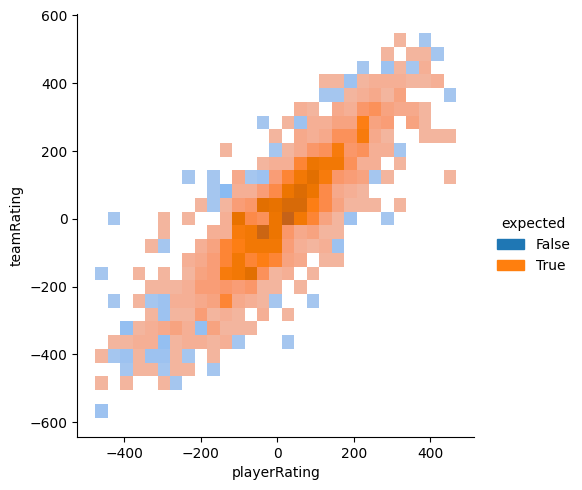

In [18]:
sbn.displot(data=reduced, x="playerRating", y="teamRating", hue='expected')

In [23]:
from scipy.stats import pearsonr, spearmanr

# Calculate Pearson correlation 
def show_correlation(column: str, compare: str):
    print(f"Show correlation of: {column} vs {compare}")

    pearson_corr, _ = pearsonr(reduced[column], reduced[compare])
    print(f"Pearson correlation: {pearson_corr}")

    # Calculate Spearman correlation 
    spearman_corr, _ = spearmanr(reduced[column], reduced[compare])
    print(f"Spearman correlation: {spearman_corr}")

show_correlation('statsRating', 'expected')
show_correlation('playerRating', 'expected')
show_correlation('teamRating', 'expected')
show_correlation('grade', 'expected')

show_correlation('statsRating', 'diff')
show_correlation('playerRating', 'diff')
show_correlation('teamRating', 'diff')
show_correlation('grade', 'diff')

print('========sanity========')
show_correlation('diff', 'expected')

Show correlation of: statsRating vs expected
Pearson correlation: 0.18505030698581293
Spearman correlation: 0.18775749023606542
Show correlation of: playerRating vs expected
Pearson correlation: 0.1875473351324891
Spearman correlation: 0.18843191564999368
Show correlation of: teamRating vs expected
Pearson correlation: 0.16510575123772447
Spearman correlation: 0.16741444441719794
Show correlation of: grade vs expected
Pearson correlation: 0.17820663986846402
Spearman correlation: 0.17644602306735116
Show correlation of: statsRating vs diff
Pearson correlation: 0.24289362775678022
Spearman correlation: 0.24512272443255775
Show correlation of: playerRating vs diff
Pearson correlation: 0.25506213108350984
Spearman correlation: 0.2540705981074421
Show correlation of: teamRating vs diff
Pearson correlation: 0.22685613417562456
Spearman correlation: 0.2216383717701212
Show correlation of: grade vs diff
Pearson correlation: 0.23994076475151785
Spearman correlation: 0.2309245964585858
========